# Flood Detection 

Importing libraries

In [31]:
import numpy as np
import tensorflow
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, Input, AveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

Creating empty arrays for pictures and their labels (flood or no_flood)

In [32]:
datafolder = "data"
pics = []
labels = []

In [33]:
for category in os.listdir(datafolder):
    path = os.path.join(datafolder, category)
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        pic = load_img(imgpath, target_size=(224,224))
        picarr = img_to_array(pic)
        pic = preprocess_input(picarr)
        
        pics.append(pic)
        labels.append(category)

print(labels[-10:])

['no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood']


In [ ]:
pic

Text Representation (changing the labels to binary labels)

In [36]:
labelbinarizer = LabelBinarizer()
labels = labelbinarizer.fit_transform(labels)
labels=to_categorical(labels)
pics = np.array(pics, dtype="float32")
labels=np.array(labels)
print(labels[-5:])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [37]:
type(pics)

numpy.ndarray

In [38]:
templabels=[]
for i in range(len(labels)):
    templabels.append(np.argmax(labels[i]))
templabels.count(1)

204

Creating image augmentations

In [39]:
aug = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

Splitting the dataset into training and testing dataset

In [77]:
(trainX, testX, trainY, testY) = train_test_split(pics,labels,test_size=0.2,stratify=labels,random_state=42) 

In [78]:
testX

array([[[[-0.64705884, -0.6       , -0.6313726 ],
         [-0.88235295, -0.8352941 , -0.8666667 ],
         [-0.88235295, -0.8352941 , -0.8509804 ],
         ...,
         [-0.6627451 , -0.6784314 , -0.67058825],
         [-0.654902  , -0.67058825, -0.6627451 ],
         [-0.78039217, -0.79607844, -0.7882353 ]],

        [[-0.60784316, -0.5529412 , -0.60784316],
         [-0.8509804 , -0.79607844, -0.8509804 ],
         [-0.88235295, -0.827451  , -0.88235295],
         ...,
         [-0.6392157 , -0.62352943, -0.70980394],
         [-0.73333335, -0.7176471 , -0.8039216 ],
         [-0.75686276, -0.7411765 , -0.827451  ]],

        [[-0.58431375, -0.52156866, -0.60784316],
         [-0.79607844, -0.73333335, -0.81960785],
         [-0.827451  , -0.7647059 , -0.8509804 ],
         ...,
         [-0.5372549 , -0.47450978, -0.654902  ],
         [-0.6313726 , -0.5686275 , -0.7490196 ],
         [-0.5764706 , -0.5137255 , -0.69411767]],

        ...,

        [[-0.6156863 , -0.54509807, -0

Creating the base model using MobileNetV2

In [79]:
base_model = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224,224,3)))

In [80]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Constructing the head of the model that will be put on top of the base model

In [81]:
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7,7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

Compiling the model

In [82]:
final_model =  Model(inputs=base_model.input, outputs=head_model)

In [83]:
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [84]:
for layer in base_model.layers:
    layer.trainable=False

In [85]:
optimizer = Adam(learning_rate=0.0001,decay=0.0001/10)
final_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=["accuracy"])


Training the model using the training dataset

In [86]:
head=final_model.fit(
    aug.flow(trainX,trainY,batch_size=32),
    steps_per_epoch=len(trainX) //32,
    validation_data= (testX, testY),
    validation_steps= len(testX)//32,
    epochs=10
)

Epoch 1/10
11/11 [==============================] - 12s 867ms/step - loss: 0.7853 - accuracy: 0.5856 - val_loss: 0.5322 - val_accuracy: 0.8478
Epoch 2/10
11/11 [==============================] - 9s 783ms/step - loss: 0.6353 - accuracy: 0.6937 - val_loss: 0.4317 - val_accuracy: 0.9457
Epoch 3/10
11/11 [==============================] - 9s 789ms/step - loss: 0.5037 - accuracy: 0.8018 - val_loss: 0.3568 - val_accuracy: 0.9565
Epoch 4/10
11/11 [==============================] - 9s 782ms/step - loss: 0.3903 - accuracy: 0.8799 - val_loss: 0.3046 - val_accuracy: 0.9565
Epoch 5/10
11/11 [==============================] - 9s 786ms/step - loss: 0.4061 - accuracy: 0.8559 - val_loss: 0.2708 - val_accuracy: 0.9565
Epoch 6/10
11/11 [==============================] - 9s 773ms/step - loss: 0.3462 - accuracy: 0.8859 - val_loss: 0.2432 - val_accuracy: 0.9674
Epoch 7/10
11/11 [==============================] - 10s 850ms/step - loss: 0.2948 - accuracy: 0.9069 - val_loss: 0.2232 - val_accuracy: 0.9674
Epoc

Using the trained model to make prediction on the test dataset and evaluating it

In [87]:
testpredict = final_model.predict(testX, batch_size=32)
testpredict = np.argmax(testpredict, axis=1)
print(classification_report(testY.argmax(axis=1), testpredict, target_names=labelbinarizer.classes_))

3/3 [==============================] - 3s 610ms/step
              precision    recall  f1-score   support

       flood       0.98      0.94      0.96        51
    no_flood       0.93      0.98      0.95        41

    accuracy                           0.96        92
   macro avg       0.95      0.96      0.96        92
weighted avg       0.96      0.96      0.96        92



Confusion matrix

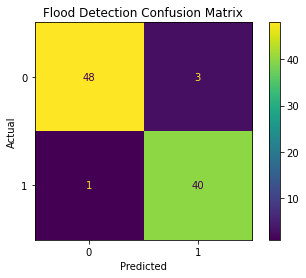

In [89]:
import matplotlib.pyplot as plt
cm = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(testY.argmax(axis=1), testpredict))
cm.plot()
cm.ax_.set(
    title='Flood Detection Confusion Matrix',
    xlabel='Predicted',
    ylabel='Actual')
plt.show()

In [16]:
final_model.save("Flood_Detection.model",save_format="h5")

In [17]:
from flask import Flask

In [95]:
testdatafolder = "testdata"
testpics = []
testlabels=[]
for category in os.listdir(testdatafolder):
    path = os.path.join(testdatafolder, category)
    for img in os.listdir(path):
        imgpath = os.path.join(path, img)
        testpic = load_img(imgpath, target_size=(224,224))
        testpic = img_to_array(testpic)
        testpic = preprocess_input(testpic)
        
        testpics.append(testpic)
        testlabels.append(category)

print(testlabels[-10:])

['no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood', 'no_flood']


In [96]:
labelbinarizer = LabelBinarizer()
testlabels = labelbinarizer.fit_transform(testlabels)
testlabels=to_categorical(testlabels)
testpics = np.array(testpics, dtype="float32")
testlabels=np.array(testlabels)
print(testlabels[-5:])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [97]:
testdatapredict = final_model.predict(testpics, batch_size=32)
testdatapredict = np.argmax(testdatapredict, axis=1)

1/1 [==============================] - 0s 443ms/step


In [98]:
testdatapredict

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [100]:
print(classification_report(testlabels.argmax(axis=1), testdatapredict, target_names=labelbinarizer.classes_))

              precision    recall  f1-score   support

       flood       1.00      1.00      1.00        11
    no_flood       1.00      1.00      1.00        11

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



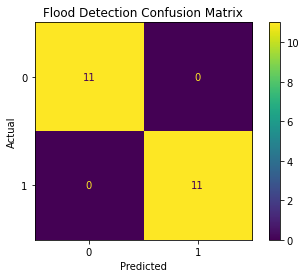

In [99]:
cm = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(testlabels.argmax(axis=1), testdatapredict))
cm.plot()
cm.ax_.set(
    title='Flood Detection Confusion Matrix',
    xlabel='Predicted',
    ylabel='Actual')
plt.show()

In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\MSIGF6~1\AppData\Local\Temp\tmphcdzulek\assets


INFO:tensorflow:Assets written to: C:\Users\MSIGF6~1\AppData\Local\Temp\tmphcdzulek\assets


In [21]:
path = "facedata"
testpics = []
for img in os.listdir(path):
    imgpath = os.path.join(path, img)
    testpic = load_img(imgpath, target_size=(224,224))
    testpic = img_to_array(testpic)
    testpic = preprocess_input(testpic)
    testpics.append(testpic)
testpics = np.array(testpics, dtype="float32")

facedatapredict = final_model.predict(testpics, batch_size=32)

1/1 [==============================] - 5s 5s/step


In [22]:
facedatapredict

array([[0.45932293, 0.5406771 ]], dtype=float32)

In [24]:
facedatapredict = np.argmax(facedatapredict, axis=1)

In [25]:
facedatapredict

array([1], dtype=int64)